In [1]:
import sys, os
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pydub
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import *
from models import *
import torchaudio
from torchaudio import transforms
import h5py as hf

/home/fleeb/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
seq_len = 2000
fs = 44100
hop = 1000

In [30]:
path = '/home/fleeb/workspace/ml_datasets/audio/musicnet/musicnet.h5'

In [4]:
model = Wav_Encoder((1, fs*seq_len//1000), out_dim=4, rec_type='lstm',
                    rec_dim=128,)# fc_dims=[64])
model

Wav_Encoder(
  (conv): Sequential(
    (0): Conv1d(1, 32, kernel_size=(40,), stride=(20,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv1d(32, 64, kernel_size=(40,), stride=(20,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Conv1d(64, 128, kernel_size=(40,), stride=(20,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): PReLU(num_parameters=1)
  )
  (rec): RecNet(
    (rec): LSTM(128, 128, batch_first=True)
  )
)

In [5]:
with hf.File(, 'r') as f:
    ids = np.array(list(f.keys()))
    lens = np.array([f[ID]['data'].shape[0] for ID in ids])
    lbls = np.array([f[ID].attrs['label'] for ID in ids])

In [37]:
trainper = 0.7
valper = 0.1

orders = util.split_vals(np.arange(len(ids)), [trainper, valper, 1 - trainper - valper])
print([len(o) for o in orders])

[229, 39, 62]


In [38]:
[np.bincount(lbls[o], minlength=4) for o in orders]

[array([ 46,  25, 153,   5]), array([10,  6, 22,  1]), array([11,  5, 44,  2])]

In [39]:
[1/(x.sum()/x) for x in _]

[array([0.20087336, 0.10917031, 0.66812227, 0.02183406]),
 array([0.25641026, 0.15384615, 0.56410256, 0.02564103]),
 array([0.17741935, 0.08064516, 0.70967742, 0.03225806])]

In [43]:
splitIds = [ids[o] for o in orders]
splitLens = [lens[o] for o in orders]
splitCats = [lbls[o] for o in orders]
print([len(s)/330 for s in splitIds])
print([l.sum()/lens.sum() for l in splitLens])
print([np.bincount(l, minlength=4) for l in splitCats])

[0.693939393939394, 0.11818181818181818, 0.18787878787878787]
[0.6690789527140047, 0.1156568446306805, 0.2152642026553148]
[array([ 46,  25, 153,   5]), array([10,  6, 22,  1]), array([11,  5, 44,  2])]


In [44]:
#torch.save({'ids':splitIds, 'lens': splitLens, 'cats':splitCats }, os.path.join(os.path.dirname(path), 'split.pth.tar'))

In [28]:
weights = np.bincount(lbls, weights=lens)

In [29]:
1 / (lens.sum() / weights)

array([0.09009661, 0.10476058, 0.77576515, 0.02937767])

In [11]:
dataset = MusicNet_Dataset('/home/fleeb/workspace/ml_datasets/audio/musicnet/musicnet.h5', 
                           seq_len=seq_len, hop=hop)
len(dataset)

122049

In [12]:
loader = DataLoader(dataset, batch_size=4, shuffle=True)
len(loader)

30513

In [13]:
for x,y in loader:
    break
x.size(), y

(torch.Size([4, 88200]), tensor([2, 2, 0, 2]))

In [14]:
out = model(x.unsqueeze(1).float())
out.size()

x torch.Size([4, 1, 88200])
y torch.Size([4, 128, 9])
yr torch.Size([4, 128])
tensor(4.2375, grad_fn=<MeanBackward1>)
out torch.Size([4, 4])


torch.Size([4, 4])

In [8]:
nn.NLLLoss()(out, y)

tensor(1.4517, grad_fn=<NllLossBackward>)

In [2]:
t, fs = torchaudio.load('example.mp3', normalization=True)
t.size(), fs

(torch.Size([3186432, 2]), 48000)

In [13]:
torchaudio.transforms.MEL2?

In [12]:
spec = torchaudio.transforms.MEL2()
spec(t).size()

TypeError: stft(): argument 'normalized' (position 5) must be bool, not Tensor

In [16]:
sig = transforms.LC2CL()(t)  # (n, c) -> (c, n)
spec_mel = transforms.MEL2(fs)(sig)  # (c, l, m)

TypeError: stft(): argument 'normalized' (position 5) must be bool, not Tensor

In [4]:
f = hf.File('/home/fleeb/workspace/ml_datasets/audio/yt/processed/track0000.h5', 'r')
list(f.keys())

['wav']

In [5]:
f['wav'].shape

(11726221,)

In [6]:
a = f['wav'].value

In [7]:
list(f.attrs.keys())

['name', 'gid', 'mid']

In [8]:
f.attrs['gid'], f.attrs['mid']

(7, 8)

In [9]:
f.attrs['name']

'Hang Ups Want You - Otis McDonald (No Copyright Music)'

In [10]:
f.close()

In [11]:
a.size / 44100

265.9007029478458

<IPython.core.display.Javascript object>


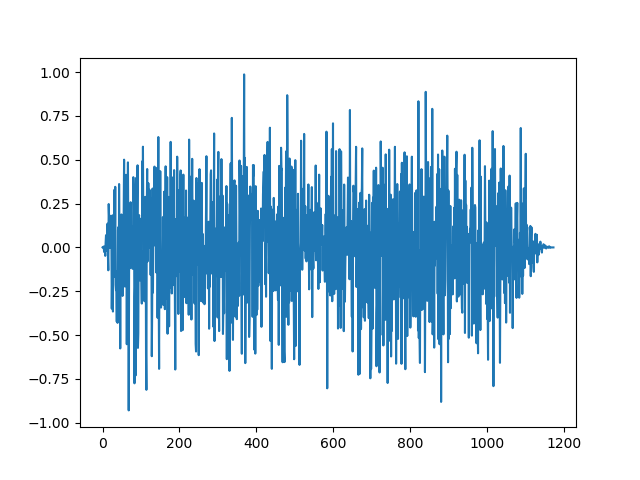

In [12]:
plt.figure()
plt.plot(a[::10000])